## About

Compare HR parameters between ECG and Apple watch

Adapted from :https://github.com/PennProjects/pioneer_wearables/commit/8db440efd9ef2e5246faa9ae0d55a99e9a88663e

In [13]:
import sys
import os

root_folder = "./../"
sys.path.insert(1, root_folder)
sys.path.insert(1, os.path.join(root_folder, 'tools/'))

from helpers import *
from ecg_hr import *
import scipy as sp
import seaborn as sns

In [14]:
importlib.reload(sys.modules['helpers'])
from helpers import *

In [15]:
subject_name = ["LB3_001_phaseII","LB3_002_phaseI", "LB3_004_phaseI", "LB3_005_phaseII", "LB3_006_phaseII", "LB3_007_phaseII"]

# subject_name = ["LB3_005_phaseII"]

#root folder contains the LB3_oox_phasey subject folder
root_folder = "/mnt/leif/littlab/data/Human_Data/LB3_PIONEER/"

temp_list= json.load(open("/users/jalp/git/pioneer_wearables/tools/subject_metadata_jp.json"))
metadata = pd.DataFrame(temp_list).T

In [16]:


#root folder contains the LB3_oox_phasey subject folder
# root_folder = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"


watch_hr = {}
acc_data = {}
ecg_hr = {}
sz_start = {}
sleep_data = {}



for s in subject_name:

    watch_hr[s] = fetch_h5(s, root_folder, "watch_heart")
    # acc_data[s] = fetch_h5(s, root_folder, "watch_acc")
    ecg_hr[s] = fetch_h5(s, root_folder, "ecg_heart")
    # sleep_data[s] = fetch_h5(s, root_folder, "watch_sleep")
    # sz_times = []
    # for i in metadata.loc[s]["Events"]["Ictal"].items():
    #     sz_times.append(pd.to_datetime(i[1]['Seizure real time']).tz_convert(tz))
    # sz_start[s] = pd.DataFrame(sz_times)




In [17]:
##Calculating sampling rate

sampling_df  = pd.DataFrame()
for s in subject_name:
    # print(s)
    

    ecg_diff = np.array((ecg_hr[s].index[1:]-ecg_hr[s].index[:-1]).seconds)
    ecg_diff = ecg_diff[ecg_diff<1800]
    temp_ = pd.DataFrame(columns=['sampling', 'source', 'subject'], data={'sampling':1/ecg_diff})
    temp_['source'] = 'ecg'
    temp_['subject'] = s
    # print(temp_.describe())
    sampling_df = sampling_df.append(temp_.dropna())

    watch_diff = np.array((watch_hr[s].index[1:]-watch_hr[s].index[:-1]).seconds)
    watch_diff = watch_diff[watch_diff<1800]
    temp_ = pd.DataFrame(columns=['sampling', 'source', 'subject'], data={'sampling':1/watch_diff})
    temp_['source'] = 'watch'
    temp_['subject'] = s
    # print(temp_.describe())
    sampling_df = sampling_df.append(temp_.dropna())



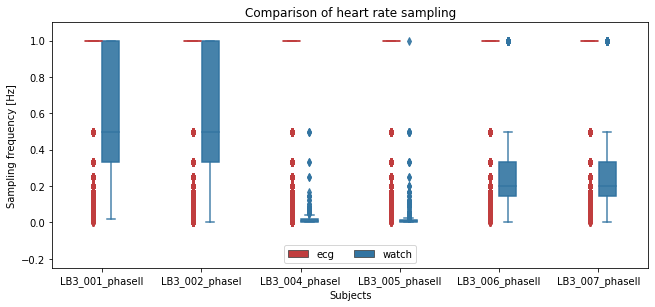

In [18]:
fig, ax = plt.subplots(1,1,figsize = [9,4])
fig.tight_layout()

plt.rcParams.update({'font.size': 10})
sns.set_style()
fig.patch.set_facecolor('xkcd:white')
width = 0.35
# matplotlib.rc_file_defaults()
a = sns.boxplot(x="subject", y="sampling", hue='source',data =sampling_df,  palette = ['C3', 'C0'], ax = ax, width = width)
# sns.swarmplot(x="subject", y="sampling", hue='source',data =sampling_df, color=".25", size=0.2, alpha=0.2)

a.set_ylim([-0.25,1.1])
a.legend(ncol=2, loc='lower center')

a.set_ylabel("Sampling frequency [Hz]")
a.set_xlabel("Subjects")
a.set_title("Comparison of heart rate sampling")

alpha = 0.7


#line color
for p in [a]:
    for i,artist in enumerate(p.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        col = [col[0], col[1], col[2], 0.9]
        artist.set_facecolor(col)

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = p.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)


# plt.savefig("./../figures/sampling_comparison.png", dpi = 300, bbox_inches='tight')
plt.show()


## Bland altman plot

In [19]:
import matplotlib
cppr = matplotlib.cm.get_cmap('copper', 2)
vir_col = matplotlib.cm.get_cmap("viridis", 3)
rckt = matplotlib.cm.get_cmap('rocket', 8)

In [20]:
def bland_altman_plot(data1, data2,combined, ax,sub, xlim, ylim, flag = 0, param_flag="ecg"):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)

    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation aof the difference

    # plt.rcParams.update({'font.size': 11})

    if flag==1:
        if (param_flag=='rmssd') or (param_flag=='hf'):
            robust = True
        else:
            robust = False
        sns.regplot(x = 'ecg', y = 'watch', data = combined, robust=robust, ax=ax, scatter_kws={'s':2, 'alpha':0.2}, color=vir_col.colors[1])
        r,p =  sp.stats.pearsonr(combined.dropna().iloc[:,0].values, combined.dropna().iloc[:,1].values)

        if p < 0.001:
            p = "< 0.001"
        elif  p < 0.05:
            p = "< 0.05"
        else:
            p = "> 0.05"

        if param_flag=="ecg":
            ax.text(70,150, "r %.2f, p %s " %(r, p), fontsize = 10)
        if param_flag=="rmssd":
            ax.text(30,90, "r %.2f, p %s " %(r, p), fontsize = 10)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_axisbelow(True)
        ax.grid(alpha = 0.3)
        

    if flag==0:
        ax.scatter(mean, diff, color = rckt.colors[3], alpha=0.8, s=0.2)
        ax.axhline(md,           color='gray', linestyle='--')
        ax.axhline(md + 1.96*sd, color='gray', linestyle='--')
        ax.axhline(md - 1.96*sd, color='gray', linestyle='--')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if param_flag=="ecg":
            ax.text(150,md, "%d" %(md))
            ax.text(150,md + 1.96*sd+10, "%d" %(md + 1.96*sd))
            ax.text(150,md - 1.96*sd-10, "%d" %(md - 1.96*sd))
        if param_flag=="rmssd":
            ax.text(90,md, "%d" %(md))
            ax.text(90,md + 1.96*sd+10, "%d" %(md + 1.96*sd))
            ax.text(90,md - 1.96*sd-10, "%d" %(md - 1.96*sd))
        ax.set_axisbelow(True)
        ax.grid(alpha=0.3)

    


  
def smooth_clean(df, param,source, resamp_dur="60min"):
    df[source] = df[param]
    return  df[source].resample(resamp_dur).mean()


In [21]:
combined_hr = {}
all_hr = pd.DataFrame()
for s in subject_name:  
    d1 = smooth_clean(ecg_hr[s], 'heartRate' ,"ecg", "10s")
    d2 = smooth_clean(watch_hr[s], 'heartRate', "watch", "10s")
    combined = pd.concat([d1, d2], axis=1)
    combined_hr[s] = combined.dropna() 
    all_hr = all_hr.append(combined_hr[s])

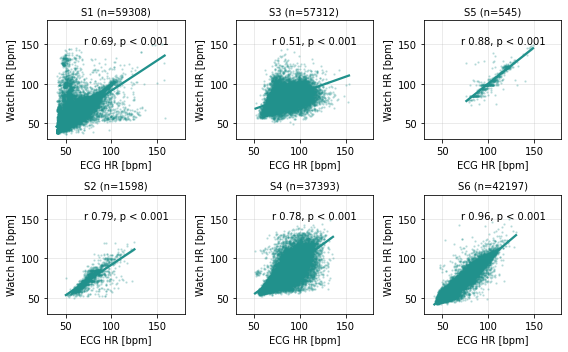

In [22]:
num = [1,3,5,2,4,6]
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')
sns.set_style()
fig, ax = plt.subplots(2,3, figsize=(8,5))

for n,a in enumerate(ax.flatten()):
    s = subject_name[n]
    bland_altman_plot(combined_hr[s].iloc[:,0].values, combined_hr[s].iloc[:,1].values, combined_hr[s], a, s, [30,180], [30,180],1)
    a.set_xlabel("ECG HR [bpm]", fontsize=10)
    a.set_ylabel("Watch HR [bpm]",  fontsize=10)
    a.set_title("S%d (n=%d)" %(num[n], len(combined_hr[s])), fontsize=10)
# plt.suptitle("ECG-Watch Heart rate correlation",  fontsize=10)
fig.tight_layout()
# plt.savefig("./../figures/corr_individual_hr.png", dpi = 300, bbox_inches='tight')
# plt.savefig("./../figures/corr_individual_hr_present.png", dpi = 300, bbox_inches='tight')

plt.show()

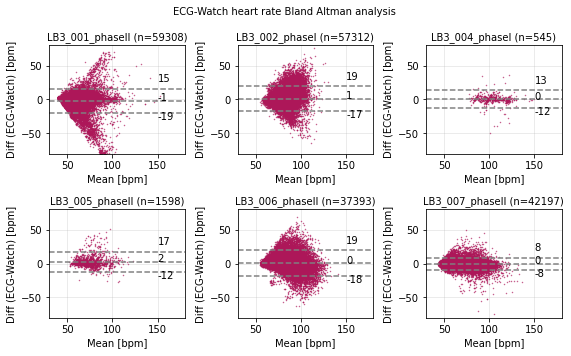

In [23]:

plt.rcParams.update({'font.size': 10})

sns.set_style()


fig, ax = plt.subplots(2,3, figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')

for n,a in enumerate(ax.flatten()): 
    s = subject_name[n]  

    bland_altman_plot(combined_hr[s].iloc[:,0].values, combined_hr[s].iloc[:,1].values, combined_hr[s], a, s,[30,180], [-80,80], 0)
    a.set_xlabel("Mean [bpm]", fontsize=10)
    a.set_ylabel("Diff (ECG-Watch) [bpm]",  fontsize=10)
    a.set_title("%s (n=%d)" %(s, len(combined_hr[s])), fontsize=10)
plt.suptitle("ECG-Watch heart rate Bland Altman analysis",  fontsize=10)
fig.tight_layout()
# plt.savefig("./../figures/BA_individual_hr", dpi = 300, bbox_inches='tight')
plt.show()

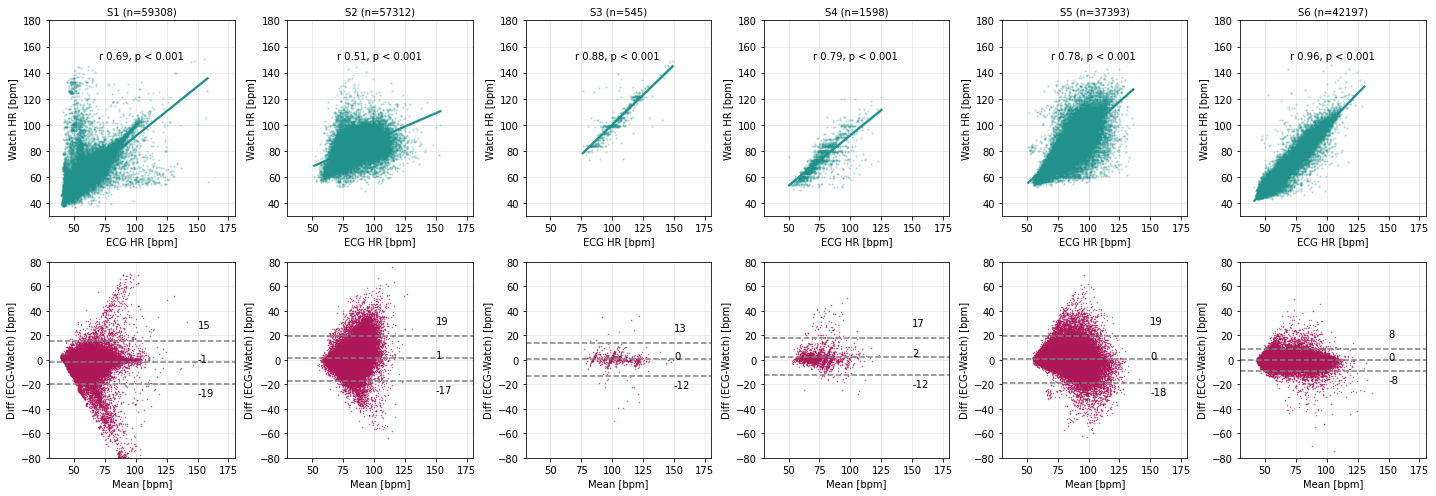

In [25]:
## Combined pearson R and blant taltman

num = [1,2,3,4,5,6]
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')
sns.set_style()
fig, ax = plt.subplots(2,6, figsize=(20,7))

for n,a in enumerate(ax.flatten()[0:6]):
    s = subject_name[n]
    bland_altman_plot(combined_hr[s].iloc[:,0].values, combined_hr[s].iloc[:,1].values, combined_hr[s], a, s, [30,180], [30,180],1)
    a.set_xlabel("ECG HR [bpm]", fontsize=10)
    a.set_ylabel("Watch HR [bpm]",  fontsize=10)
    a.set_title("S%d (n=%d)" %(num[n], len(combined_hr[s])), fontsize=10)

for n,a in enumerate(ax.flatten()[6:12]): 
    s = subject_name[n]  

    bland_altman_plot(combined_hr[s].iloc[:,0].values, combined_hr[s].iloc[:,1].values, combined_hr[s], a, s,[30,180], [-80,80], 0)
    a.set_xlabel("Mean [bpm]", fontsize=10)
    a.set_ylabel("Diff (ECG-Watch) [bpm]",  fontsize=10)
    # a.set_title("%s (n=%d)" %(s, len(combined_hr[s])), fontsize=10)

    
# plt.suptitle("ECG-Watch Heart rate correlation",  fontsize=10)
fig.tight_layout()
# plt.savefig("./../figures/corr_individual_hr.png", dpi = 300, bbox_inches='tight')
# plt.savefig("./../figures/corr_individual_hr_present.png", dpi = 300, bbox_inches='tight')

plt.show()

In [26]:
def bland_altman_single(data1, data2,combined, xlim1, ylim1,xlim2, ylim2, param_flag="ecg"):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)

    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation aof the difference

    plt.rcParams.update({'font.size': 10})
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    fig.patch.set_facecolor('xkcd:white')
    sns.set_style()
    


    axi = ax[0]
    if (param_flag=='rmssd') or (param_flag=='hf'):
        robust = True
    else:
        robust = False

    sns.regplot(x = 'ecg', y = 'watch', data = combined,robust = robust, ax=axi, scatter_kws={'s':2, 'alpha':0.2}, color=vir_col.colors[1])
    r,p =  sp.stats.pearsonr(combined.dropna().iloc[:,0].values, combined.dropna().iloc[:,1].values)

    if p < 0.001:
        p = "< 0.001"
    elif  p < 0.05:
        p = "< 0.05"
    else:
        p = "> 0.05"


    if param_flag=="ecg":
        axi.text(70,150, "r %.2f, p %s " %(r, p), fontsize = 10)

    if param_flag=="rmssd":
        axi.text(30,90, "r %.2f, p %s " %(r, p), fontsize = 10)

    axi.set_xlim(xlim1)
    axi.set_ylim(ylim1)
    axi.set_axisbelow(True)
    axi.grid(alpha = 0.3)


    axi = ax[1]
    axi.scatter(mean, diff, color = rckt.colors[3], alpha=0.8, s=0.2)
    axi.axhline(md,           color='gray', linestyle='--')
    axi.axhline(md + 1.96*sd, color='gray', linestyle='--')
    axi.axhline(md - 1.96*sd, color='gray', linestyle='--')
    axi.set_xlim(xlim2)
    axi.set_ylim(ylim2)
    if param_flag=="ecg":
        axi.text(150,md, "%d" %(md))
        axi.text(150,md + 1.96*sd+5, "%d" %(md + 1.96*sd))
        axi.text(150,md - 1.96*sd-10, "%d" %(md - 1.96*sd))
    if param_flag=="rmssd":
        axi.text(90,md, "%d" %(md))
        axi.text(90,md + 1.96*sd+5, "%d" %(md + 1.96*sd))
        axi.text(90,md - 1.96*sd-10, "%d" %(md - 1.96*sd))
    axi.set_axisbelow(True)
    axi.grid(alpha=0.3)

    return ax



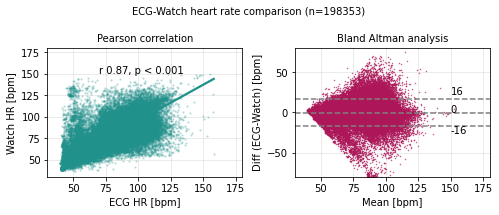

In [27]:
ax = bland_altman_single(all_hr.iloc[:,0].values, all_hr.iloc[:,1].values, all_hr, [30,180], [30,180], [30,180], [-80,80], "ecg")
axi = ax[0]
axi.set_xlabel("ECG HR [bpm]", fontsize=10)
axi.set_ylabel("Watch HR [bpm]", fontsize=10)
axi.set_title("Pearson correlation", fontsize=10)

axi = ax[1]
axi.set_xlabel("Mean [bpm]", fontsize=10)
axi.set_ylabel("Diff (ECG-Watch) [bpm]", fontsize=10)
axi.set_title("Bland Altman analysis", fontsize=10)


plt.suptitle("ECG-Watch heart rate comparison (n=%d)"%(len(all_hr)), fontsize=10)
plt.tight_layout()
# plt.savefig("./../figures/comparison_all_hr", dpi = 300, bbox_inches='tight')
plt.show()


## RMSSD comparison

In [28]:
combined_rmssd = {}
all_rmssd = pd.DataFrame()
for s in subject_name:  
    d1 = smooth_clean(ecg_hr[s], 'rmssd' ,"ecg", "5min")
    d2 = smooth_clean(watch_hr[s], 'rmssd', "watch", "5min")
    combined = pd.concat([d1, d2], axis=1)
    combined_rmssd[s] = combined.dropna() 
    all_rmssd = all_rmssd.append(combined_rmssd[s])

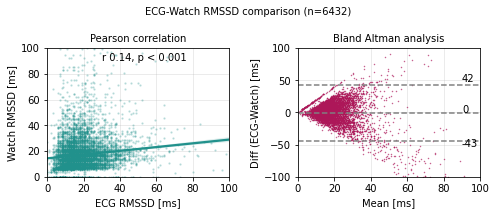

In [29]:
ax = bland_altman_single(all_rmssd.iloc[:,0].values, all_rmssd.iloc[:,1].values, all_rmssd, [0,100], [0,100], [0,100], [-100,100], "rmssd")
axi = ax[0]
axi.set_xlabel("ECG RMSSD [ms]", fontsize=10)
axi.set_ylabel("Watch RMSSD [ms]", fontsize=10)
axi.set_title("Pearson correlation", fontsize=10)

axi = ax[1]
axi.set_xlabel("Mean [ms]", fontsize=10)
axi.set_ylabel("Diff (ECG-Watch) [ms]", fontsize=10)
axi.set_title("Bland Altman analysis", fontsize=10)


plt.suptitle("ECG-Watch RMSSD comparison (n=%d)"%(len(all_rmssd)), fontsize=10)
plt.tight_layout()
# plt.savefig("./../figures/comparsion_all_rmssd", dpi = 300, bbox_inches='tight')
plt.show()


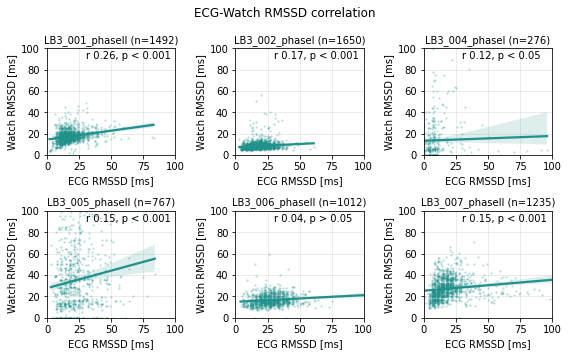

In [30]:
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')
sns.set_style()
fig, ax = plt.subplots(2,3, figsize=(8,5))

for n,a in enumerate(ax.flatten()):
    s = subject_name[n]
    bland_altman_plot(combined_rmssd[s].iloc[:,0].values, combined_rmssd[s].iloc[:,1].values, combined_rmssd[s], a, s, [0,100], [0,100],1, "rmssd")
    a.set_xlabel("ECG RMSSD [ms]")
    a.set_ylabel("Watch RMSSD [ms]")
    a.set_title("%s (n=%d)" %(s, len(combined_rmssd[s])), fontsize=10)
plt.suptitle("ECG-Watch RMSSD correlation")
fig.tight_layout()
# plt.savefig("./../figures/corr_individual_rmssd.png", dpi = 300, bbox_inches='tight')
plt.show()

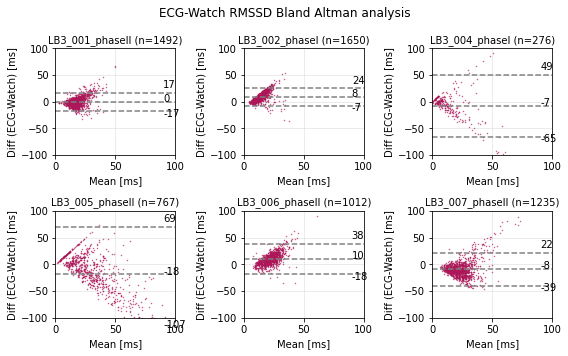

In [31]:
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')
sns.set_style()
fig, ax = plt.subplots(2,3, figsize=(8,5))

for n,a in enumerate(ax.flatten()):
    s = subject_name[n]
    bland_altman_plot(combined_rmssd[s].iloc[:,0].values, combined_rmssd[s].iloc[:,1].values, combined_rmssd[s], a, s, [0,100], [-100,100],0, "rmssd")
    a.set_xlabel("Mean [ms]", fontsize=10)
    a.set_ylabel("Diff (ECG-Watch) [ms]", fontsize=10)
    a.set_title("%s (n=%d)" %(s, len(combined_rmssd[s])), fontsize=10)
plt.suptitle("ECG-Watch RMSSD Bland Altman analysis")
fig.tight_layout()
# plt.savefig("./../figures/BA_individual_rmssd.png", dpi = 300, bbox_inches='tight')
plt.show()

## HF comparison

In [32]:
combined_hf = {}
all_hf = pd.DataFrame()
for s in subject_name:  
    d1 = smooth_clean(ecg_hr[s], 'hf' ,"ecg", "5min")
    d2 = smooth_clean(watch_hr[s], 'hf', "watch", "5min")
    combined = pd.concat([d1, d2], axis=1)
    combined_hf[s] = combined.dropna() 
    all_hf = all_rmssd.append(combined_hf[s])

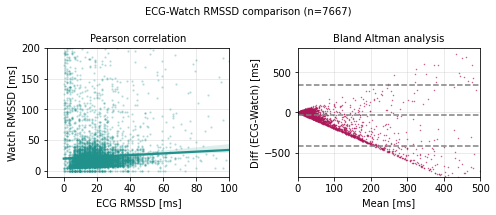

In [33]:
ax = bland_altman_single(all_hf.iloc[:,0].values, all_hf.iloc[:,1].values, all_hf, [-10,100], [-10,200], [0,500], [-800,800], "hf")
axi = ax[0]
axi.set_xlabel("ECG RMSSD [ms]", fontsize=10)
axi.set_ylabel("Watch RMSSD [ms]", fontsize=10)
axi.set_title("Pearson correlation", fontsize=10)

axi = ax[1]
axi.set_xlabel("Mean [ms]", fontsize=10)
axi.set_ylabel("Diff (ECG-Watch) [ms]", fontsize=10)
axi.set_title("Bland Altman analysis", fontsize=10)


plt.suptitle("ECG-Watch RMSSD comparison (n=%d)"%(len(all_hf)), fontsize=10)
plt.tight_layout()

plt.show()


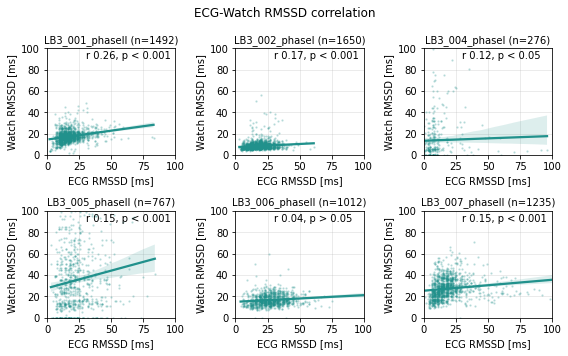

In [34]:
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')
sns.set_style()
fig, ax = plt.subplots(2,3, figsize=(8,5))

for n,a in enumerate(ax.flatten()):
    s = subject_name[n]
    bland_altman_plot(combined_rmssd[s].iloc[:,0].values, combined_rmssd[s].iloc[:,1].values, combined_rmssd[s], a, s, [0,100], [0,100],1, "rmssd")
    a.set_xlabel("ECG RMSSD [ms]")
    a.set_ylabel("Watch RMSSD [ms]")
    a.set_title("%s (n=%d)" %(s, len(combined_rmssd[s])), fontsize=10)
plt.suptitle("ECG-Watch RMSSD correlation")
fig.tight_layout()
# plt.savefig("./../figures/corr_individual_rmssd.png", dpi = 300, bbox_inches='tight')
plt.show()

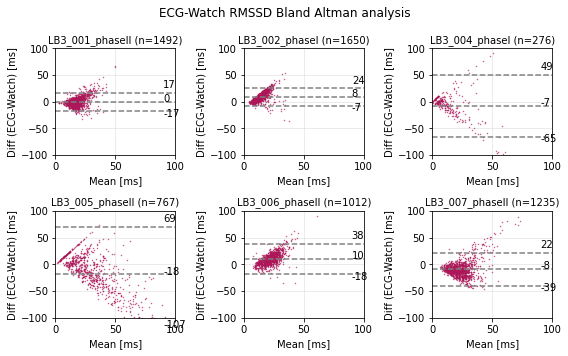

In [35]:
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')
sns.set_style()
fig, ax = plt.subplots(2,3, figsize=(8,5))

for n,a in enumerate(ax.flatten()):
    s = subject_name[n]
    bland_altman_plot(combined_rmssd[s].iloc[:,0].values, combined_rmssd[s].iloc[:,1].values, combined_rmssd[s], a, s, [0,100], [-100,100],0, "rmssd")
    a.set_xlabel("Mean [ms]", fontsize=10)
    a.set_ylabel("Diff (ECG-Watch) [ms]", fontsize=10)
    a.set_title("%s (n=%d)" %(s, len(combined_rmssd[s])), fontsize=10)
plt.suptitle("ECG-Watch RMSSD Bland Altman analysis")
fig.tight_layout()
# plt.savefig("./../figures/BA_individual_rmssd.png", dpi = 300, bbox_inches='tight')
plt.show()